# Demo1 

In [1]:
%matplotlib inline
import gc
import pdet
import time
import fpfs
import wselutil

import numpy as np
import matplotlib.pyplot as plt
import numpy.lib.recfunctions as rfn

## image simulation
+ fpfs.simutil.sim_test is the test to simulation simple galaxy image and test shear estimation

SNR is inf
0.023523938 0.023523938


/var/tmp/pbs.100536.idark/ipykernel_81775/474466019.py:10: RuntimeWarning: divide by zero encountered in true_divide
  print('SNR is %.2f' %(flux_gal/(noi_std*5)))
/var/tmp/pbs.100536.idark/ipykernel_81775/474466019.py:13: RuntimeWarning: divide by zero encountered in true_divide
  _=plt.title(r'SNR=$%.2f$'%(flux_gal/(noi_std*5)),fontsize=20)


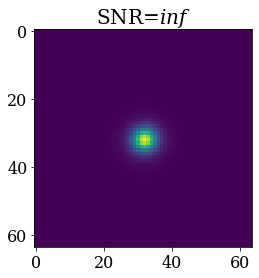

In [2]:
rng     =   np.random.RandomState(212)
ngrid   =   64
testTask=   fpfs.simutil.sim_test(shear=[0,0],rng=rng,ngrid=ngrid)

noi_std =   0.
sims= testTask.make_image(noise=noi_std,psf_noise=0.)
gal = sims[0]
psf = sims[1]
flux_gal=   np.sum(testTask.img[ngrid//2-2:ngrid//2+3,ngrid//2-2:ngrid//2+3])
print('SNR is %.2f' %(flux_gal/(noi_std*5)))
plt.close()
plt.imshow(gal)
_=plt.title(r'SNR=$%.2f$'%(flux_gal/(noi_std*5)),fontsize=20)
print(gal.max(),gal[32,32])

In [3]:
np.unravel_index(np.argmax(gal),(64,64))

(32, 32)

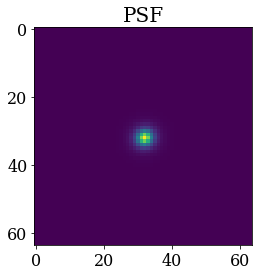

In [4]:
plt.close()
plt.imshow(psf)
_=plt.title('PSF',fontsize=20)

In [5]:
psf.max(),psf[32,32]

(0.049834613, 0.049834613)

## shear estimation
+ fpfs.fpfsBase.fpfsTask is the task to measure shear from galaxies

In [49]:
indsAll=[]
indsAll.append((2,2))
indsAll.append((2,1))
indsAll.append((2,3))
indsAll.append((1,2))
indsAll.append((3,2))

dccAll=[]
dccAll.append(0.01)
for _ in range(len(indsAll)-1):
    dccAll.append(1e-3)
cutAll=[]
cutAll.append(0.015)
for _ in range(len(indsAll)-1):
    cutAll.append(1.5e-3)
    
def analyze_FPFS(rng, input_shear, num_gals,noi_stds,noi_psf=0.):
    noi_stds=   np.array(noi_stds)
    
    if len(noi_stds.shape)==0:
        noi_stds=np.array([noi_stds])
    elif len(noi_stds.shape)>=2:
        raise ValueError('The input noi_stds should be float or 1d list')
    x       =   []      # SNR
    y       =   []      # estimated shear
    y_err   =   []      # error on shear
    # I am calling this task to simulate galaxy images:
    # https://github.com/mr-superonion/FPFS/blob/188ba8679b4db401129e7504ea5126143bafdee4/fpfs/simutil.py#L163
    ngrid   =   64
    testTask=   fpfs.simutil.sim_test(shear=input_shear,rng=rng,ngrid=ngrid)
    # get an aperture flux for SNR estimation
    gal =   testTask.make_image(noise=0.,psf_noise=noi_psf)[0]
    flux_gal=   np.sum(gal[ngrid//2-2:ngrid//2+3,ngrid//2-2:ngrid//2+3])
    # cutout PSF
    rcut    =   16
    beg     =   ngrid//2-rcut
    end     =   beg+2*rcut
    # cutout PSF into postage stamp with width=2rcut
    psf     =   testTask.psf[beg:end,beg:end]
    gc.collect()
    num_tests=  noi_stds.size
    for i in range(num_tests):
        noii    =   noi_stds[i]
        print(noii)
        x.append(flux_gal/(noii*5))
        # initialize FPFS task with an average psf and noise variance (or power spectrum)
        # beta<1 is the FPFS scale parameter
        fpTask  =   fpfs.fpfsBase.fpfsTask(psf,noiFit=noii**2.,beta=0.75)
        start= time.time()
        results =   []
        for _ in range(num_gals):
            # simulate one galaxy
            doShift=False
            gal =   testTask.make_image(noise=noii,psf_noise=noi_psf,do_shift=doShift)[0]
            
            if not doShift:
                coords  =   np.array(np.zeros(1),dtype=[('pdet_y','i4'),('pdet_x','i4')])
                coords['pdet_y']=   32
                coords['pdet_x']=   32
            else:
                coords = None
            out1=   pdet.get_shear_response_rfft(gal,testTask.psf,gsigma=fpTask.sigmaF,\
                    coords=coords,thres=noii*1)
            if len(out1)>0:
                imgList =   [gal[cc['pdet_y']-rcut:cc['pdet_y']+rcut,\
                        cc['pdet_x']-rcut:cc['pdet_x']+rcut] for cc in out1]
                # FPFS measurement
                modes   =   fpTask.measure(imgList)
                # detection array
                modes   =   rfn.merge_arrays([modes,out1],flatten=True,usemask=False)
                out1    =   pdet.peak2det(modes)
                modes   =   rfn.merge_arrays([modes,out1],flatten=True,usemask=False)
                # append measured modes to the results list
                results.append(modes)
                del modes
            del gal,out1,imgList
        end =   time.time()
        print('%.5f seconds to process %d galaxies' %(end-start,num_gals))
        mms =   rfn.stack_arrays(results,usemask=False)
        print(len(mms))
        # set C = std(\delta M_00) * 5.
        C   =   np.sqrt(np.average(mms['fpfs_N00N00']))*5.
        ells=   fpfs.fpfsBase.fpfsM2E(mms,const=C,noirev=True)
        ells=   rfn.merge_arrays([ells,mms],flatten=True,usemask=False)

        # weight array
        ws1 = np.ones(len(ells))
        for _ in range(len(cutAll)):
            pn='v%d%d' %indsAll[_]
            _wtmp= wselutil.truncSine_func(ells['pdet_%s' %pn],mu=cutAll[_],sigma=dccAll[_])
            ws1=ws1*_wtmp
        del mms,results,fpTask
        
        corg1,corg2 = wselutil.get_detbias_list(ells,ws1,indsAll,cutAll,dccAll)
        resp=np.sum(ells['fpfs_RE']*ws1)+corg1
        shear=np.sum(ells['fpfs_e1']*ws1)/resp
        shear_err=np.sqrt(np.sum(ells['fpfs_e1']**2.*ws1**2.))/np.abs(resp)
        
        y.append(shear)
        y_err.append(shear_err)
    return np.array(x),np.array(y), np.array(y_err)

In [50]:
# the processing time here includes time to simulate galaxies
noi_stds=   np.logspace(-4, -2, 4, base=10.0)
num_gals=   100000
snr,g1,g1err=   analyze_FPFS(rng,np.array([0.03, 0.00]),num_gals,noi_stds)
gc.collect()

0.0001
137.45067 seconds to process 100000 galaxies
100000
apply cut on pdet_v22 at 0.015
apply cut on pdet_v21 at 0.002
apply cut on pdet_v23 at 0.002
apply cut on pdet_v12 at 0.002
apply cut on pdet_v32 at 0.002
0.00046415888336127773
137.04607 seconds to process 100000 galaxies
100000
apply cut on pdet_v22 at 0.015
apply cut on pdet_v21 at 0.002
apply cut on pdet_v23 at 0.002
apply cut on pdet_v12 at 0.002
apply cut on pdet_v32 at 0.002
0.002154434690031882
138.75336 seconds to process 100000 galaxies
100000
apply cut on pdet_v22 at 0.015
apply cut on pdet_v21 at 0.002
apply cut on pdet_v23 at 0.002
apply cut on pdet_v12 at 0.002
apply cut on pdet_v32 at 0.002
0.01
138.18471 seconds to process 100000 galaxies
100000
apply cut on pdet_v22 at 0.015
apply cut on pdet_v21 at 0.002
apply cut on pdet_v23 at 0.002
apply cut on pdet_v12 at 0.002
apply cut on pdet_v32 at 0.002


0

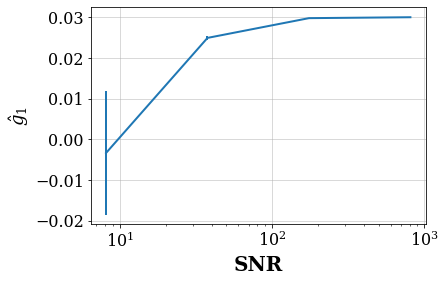

In [51]:
plt.close()
plt.errorbar(snr,g1,g1err)
plt.xlabel('SNR',fontsize=20,weight='bold')
plt.ylabel(r'$\hat{g}_1$')
plt.grid()
plt.xscale('log')